# Kaggle - TMDB

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import math

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score

### Original language

In [4]:
l_rev = {'en': 16.201695631547217,
 'fr': 13.718204235553607,
 'ru': 13.815132182879807,
 'es': 14.645970166012837,
 'hi': 15.371121660763546,
 'ja': 15.818050019285394,
 'it': 14.610307296701814,
 'ko': 14.561503498231747,
 'cn': 15.720496475312752,
 'zh': 15.246036823468886,
 'de': 14.583008872938295,
 'ta': 15.073328869838628}

In [5]:
train['l_rev'] = train['original_language'].map(l_rev).fillna(13.61844005781211)

### Collection

In [6]:
train['coll_id'] = train['belongs_to_collection'].fillna('[{"id":0}]').map(lambda x: (ast.literal_eval(x))[0]['id'])

In [7]:
colls = pd.read_csv('collections.csv',index_col=0)

In [8]:
train['coll_rev_logav'] = train['coll_id'].map(colls['log_of_averages']).fillna(0)

### genres

In [9]:
genres = pd.read_csv('genres.csv',index_col=0)

In [14]:
train['genres_id'] = train['genres'].fillna('[{"id":-1}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])

In [15]:
gen_rev = dict(genres['log_revenue'])

In [16]:
null_mean = train[train['genres'].isnull()]['revenue'].map(math.log).mean()

In [17]:
gen_rev[-1] = null_mean

In [18]:
train['genre_ave'] = train['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).mean())

### production company

In [19]:
train['production_ids'] = train['production_companies'].fillna('[{"id":-123}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])

In [20]:
productions = pd.read_csv('production_companies_short.csv',index_col=0)

In [21]:
prod_rev = dict(productions['revenue'])

In [22]:
train['production_revs'] = train['production_ids'].map(lambda x: ([prod_rev[p] for p in x if p in prod_rev]))

In [23]:
train['prod_ave'] = train['production_revs'].map(lambda x: np.array(x).mean() if len(x)>0 else 0)
train['prod_top'] = train['production_revs'].map(lambda x: np.array(x).max() if len(x)>0 else 0)

### release_date

In [24]:
train['month'] = train['release_date'].map(lambda x: (x.split('/'))[0])
train['year'] = train['release_date'].map(lambda x: (x.split('/'))[2])
train['month'] = train['month'].astype(int)
train['year'] = train['year'].astype(int)
train['year'] = train['year'].map(lambda x: x+1900 if x>17 else x+2000)

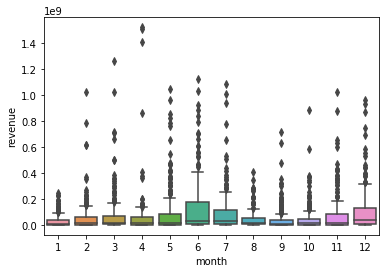

In [30]:
sns.boxplot(y=train['revenue'],x=train['month'])

In [41]:
month_rev = dict(np.log(train.groupby(by='month')['revenue'].mean()))

In [42]:
train['month_rev'] = train['month'].map(month_rev)

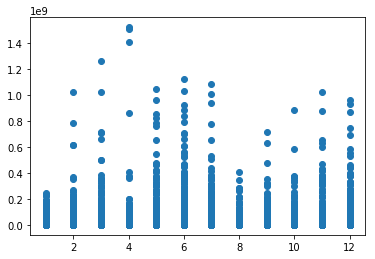

In [43]:
plt.scatter(train['month'],train['revenue'])

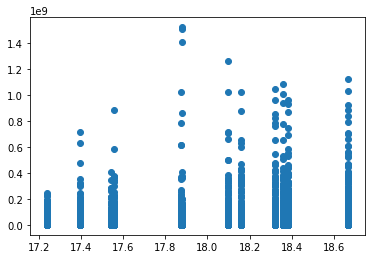

In [44]:
plt.scatter(train['month_rev'],train['revenue'])

In [68]:
month_med = dict(np.log(train.groupby(by='month')['revenue'].median()))

### Fitting

In [45]:
boost = GradientBoostingRegressor()

In [46]:
y = train['revenue'].map(math.log)

In [47]:
# best score so far (reference)
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year']

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.096882205764132

In [48]:
# best score so far (reference)
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','month_rev']

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.047251448069713

### Test set

In [49]:
test['l_rev'] = test['original_language'].map(l_rev).fillna(13.61844005781211)

In [50]:
test['coll_id'] = test['belongs_to_collection'].fillna('[{"id":0}]').map(lambda x: (ast.literal_eval(x))[0]['id'])
test['coll_rev_logav'] = test['coll_id'].map(colls['log_of_averages']).fillna(0)

In [51]:
test['genres_id'] = test['genres'].fillna('[{"id":-1}]').map(lambda x: [i['id'] for i in (ast.literal_eval(x))])
test['genre_ave'] = test['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).mean())

In [52]:
test['production_ids'] = test['production_companies'].fillna('[{"id":-123}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])

In [53]:
test['production_revs'] = test['production_ids'].map(lambda x: ([prod_rev[p] for p in x if p in prod_rev]))

In [54]:
test['prod_ave'] = test['production_revs'].map(lambda x: np.array(x).mean() if len(x)>0 else 0)
test['prod_top'] = test['production_revs'].map(lambda x: np.array(x).max() if len(x)>0 else 0)

In [55]:
# missing value - I filled with wikipedia info
test.loc[828,'release_date'] = '05/01/00'

In [59]:
test['month'] = test['release_date'].map(lambda x: (x.split('/'))[0])
test['year'] = test['release_date'].map(lambda x: (x.split('/'))[2])
test['month'] = test['month'].astype(int)
test['year'] = test['year'].astype(int)
test['year'] = test['year'].map(lambda x: x+1900 if x>17 else x+2000)
test['month_rev'] = test['month'].map(month_rev)

In [60]:
submit = pd.read_csv('sample_submission.csv',index_col='id')
submit.head()

,revenue
id,
3001,1000000
3002,1000000
3003,1000000
3004,1000000
3005,1000000


In [61]:
X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0103-month_rev_ave.csv')

In [69]:
train['month_med'] = train['month'].map(month_med)
test['month_med'] = test['month'].map(month_med)

columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','month_med']

X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0103-month_rev_med.csv')

In [71]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','month_med','month_rev','month']

X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0103-month_all.csv')